In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [6]:
n = 1250 # 0.8 split -> 1000 samples
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
path ../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
path ../datasets/drum_midi//

path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM Triplets
path ../datasets/drum_midi//60´s Drummer MIDI Files/Early Kit/02 Blues Rock/01 Clutch 90BPM


Encoding midi-data
 1250
> -> multi-track = True none
 [INFO] : 
 |  True


In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [8]:
x_train.shape

(1250, 160, 10, 1)

In [9]:
m = int(x_train.shape[0] * 0.8)
x_train.shape, m

((1250, 160, 10, 1), 1000)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 10)


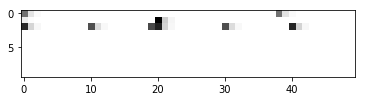

m (50, 10)


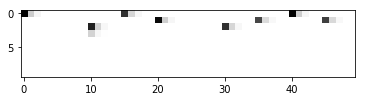

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U125')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [13]:
latent_dim = 10
epsilon_std = 1.0

In [14]:
encoder_model, encoder_input, z_mean, z_log_var = models.encoder(input_shape, latent_dim)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 10, 1)   0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 160, 10)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 159, 64)      1344        reshape_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [15]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [16]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [17]:
decoders = models.list_decoders(input_shape)
decoded = utils.composition(decoders, z_output, verbose=False)

In [18]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 10, 1)   0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 10), (None,  204116      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2816        lambda_2[0][0]                   
__________

In [19]:
# vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [20]:
vae_loss = models.vae_loss(vae_input, vae_output, z_mean, z_log_var, timesteps, notes, beta=0.75, gamma=0.05)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "reshape_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_2" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
K.int_shape(z_mean)

(None, 10)

In [22]:
batch_size = 128
epochs = 1000
params = {'batch_size': batch_size, 'return_y': False}

In [23]:
phase_mod = 0.01
whitening = False

In [24]:
m = 1000
useDataGenerator = False
# useDataGenerator = True
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

x = x_train[:m]
# x = x_train
# i = [0,1, 7,8, 14,15, 399,400]
# x = x_train[i]
# x = np.concatenate([x for _ in range(10)])
print('x:', x.shape)

print('batch_size: %i' % batch_size)
print('update-iterations:', round(epochs * x.shape[0] / batch_size))
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
    history = h.history

x: (1000, 160, 10, 1)
batch_size: 128
update-iterations: 78125
Train on 1000 samples, validate on 250 samples
Epoch 1/10000
1000/1000 [==============================] - 19s 19ms/step - loss: 479.0219 - val_loss: 156.6868
Epoch 2/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 137.6559 - val_loss: 136.4365
Epoch 3/10000
1000/1000 [==============================] - 20s 20ms/step - loss: 131.8338 - val_loss: 135.4863
Epoch 4/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 130.7933 - val_loss: 134.2800
Epoch 5/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 130.0408 - val_loss: 133.4231
Epoch 6/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 129.3363 - val_loss: 133.0687
Epoch 7/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 128.7845 - val_loss: 132.7453
Epoch 8/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 128.0152 - val_loss: 131.5723
Ep

1000/1000 [==============================] - 14s 14ms/step - loss: 80.2921 - val_loss: 82.8801
Epoch 75/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 80.1541 - val_loss: 82.5006
Epoch 76/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 80.5428 - val_loss: 83.0541
Epoch 77/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 80.1566 - val_loss: 82.8041
Epoch 78/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 80.0170 - val_loss: 82.7810
Epoch 79/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 79.9905 - val_loss: 82.5971
Epoch 80/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 79.9704 - val_loss: 82.4257
Epoch 81/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 79.6046 - val_loss: 82.7297
Epoch 82/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 79.1155 - val_loss: 83.2353
Epoch 83/10000
1000/1000 

Epoch 222/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.4100 - val_loss: 86.3369
Epoch 223/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.3517 - val_loss: 86.0737
Epoch 224/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.2992 - val_loss: 87.1663
Epoch 225/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.4727 - val_loss: 86.7708
Epoch 226/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.9683 - val_loss: 88.7389
Epoch 227/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 66.8108 - val_loss: 86.5676
Epoch 228/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.7646 - val_loss: 88.7942
Epoch 229/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.7572 - val_loss: 86.4534
Epoch 230/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 65.3700 - val_loss: 87.0749
E

Epoch 296/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.8430 - val_loss: 93.1238
Epoch 297/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 62.4894 - val_loss: 91.5998
Epoch 298/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.5921 - val_loss: 92.2562
Epoch 299/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.8110 - val_loss: 96.0530
Epoch 300/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.3676 - val_loss: 92.6391
Epoch 301/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.2072 - val_loss: 93.1756
Epoch 302/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 60.8861 - val_loss: 92.4795
Epoch 303/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 61.4017 - val_loss: 93.1915
Epoch 304/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 60.9139 - val_loss: 91.7366
E

Epoch 370/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 59.0794 - val_loss: 95.6714
Epoch 371/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.4549 - val_loss: 95.2271
Epoch 372/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.5757 - val_loss: 97.0030
Epoch 373/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.4813 - val_loss: 95.1643
Epoch 374/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.2913 - val_loss: 96.3642
Epoch 375/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.4200 - val_loss: 95.7773
Epoch 376/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.6810 - val_loss: 94.4670
Epoch 377/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.6334 - val_loss: 96.1094
Epoch 378/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 58.1717 - val_loss: 95.2480
E

1000/1000 [==============================] - 13s 13ms/step - loss: 54.6954 - val_loss: 102.2776
Epoch 517/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.2511 - val_loss: 103.0685
Epoch 518/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.9736 - val_loss: 101.8901
Epoch 519/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.0449 - val_loss: 102.6211
Epoch 520/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.1547 - val_loss: 101.2224
Epoch 521/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 53.8834 - val_loss: 101.5630
Epoch 522/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.5415 - val_loss: 104.1293
Epoch 523/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.1593 - val_loss: 102.4352
Epoch 524/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 54.3725 - val_loss: 102.4315
Epoch 52

1000/1000 [==============================] - 13s 13ms/step - loss: 52.9208 - val_loss: 107.8959
Epoch 663/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 53.0870 - val_loss: 108.5656
Epoch 664/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 51.9778 - val_loss: 111.4238
Epoch 665/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 52.8035 - val_loss: 107.4664
Epoch 666/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 52.7907 - val_loss: 108.4263
Epoch 667/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 53.0978 - val_loss: 111.2266
Epoch 668/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 52.6449 - val_loss: 108.2161
Epoch 669/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 52.5657 - val_loss: 106.0131
Epoch 670/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 51.9247 - val_loss: 108.0607
Epoch 67

1000/1000 [==============================] - 13s 13ms/step - loss: 50.3931 - val_loss: 111.7311
Epoch 809/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.1665 - val_loss: 110.9934
Epoch 810/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.2541 - val_loss: 113.2555
Epoch 811/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.3966 - val_loss: 112.2079
Epoch 812/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.5538 - val_loss: 111.9651
Epoch 813/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.5023 - val_loss: 113.2212
Epoch 814/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.3422 - val_loss: 113.8077
Epoch 815/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.1818 - val_loss: 113.2447
Epoch 816/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 50.0896 - val_loss: 114.7058
Epoch 81

1000/1000 [==============================] - 13s 13ms/step - loss: 49.4222 - val_loss: 113.4999
Epoch 955/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.7193 - val_loss: 116.4863
Epoch 956/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.9639 - val_loss: 117.5762
Epoch 957/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 49.2011 - val_loss: 115.2347
Epoch 958/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 49.8875 - val_loss: 118.1766
Epoch 959/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 49.6577 - val_loss: 118.3682
Epoch 960/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 49.0178 - val_loss: 114.7591
Epoch 961/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.8678 - val_loss: 116.6589
Epoch 962/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 49.6915 - val_loss: 116.3376
Epoch 96

1000/1000 [==============================] - 13s 13ms/step - loss: 49.2542 - val_loss: 116.0059
Epoch 1028/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.4298 - val_loss: 115.6709
Epoch 1029/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.7469 - val_loss: 118.1420
Epoch 1030/10000
1000/1000 [==============================] - 13s 13ms/step - loss: 48.5778 - val_loss: 116.6813
Epoch 1031/10000
1000/1000 [==============================] - 14s 14ms/step - loss: 54.2560 - val_loss: 117.0412
Epoch 1032/10000
1000/1000 [==============================] - 15s 15ms/step - loss: 50.7913 - val_loss: 112.2225
Epoch 1033/10000
 832/1000 [=======================>......] - ETA: 2s - loss: 49.4925

KeyboardInterrupt: 

In [25]:
fn = config.model_dir + 'hi_res-v3p-4_vae-1000.h5'

In [26]:
# for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
#     model.save_weights(dn + prefix + suffix + '.h5', "w")
vae.save_weights(fn, "w")

In [28]:
# io.save_dict(history)
io.save_dict('../logs/','train_loss', history)

NameError: name 'history' is not defined

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,150)

NameError: name 'history' is not defined

In [ ]:
# vae.load_weights(fn)

In [ ]:
# vae2 = vae

In [ ]:
x.shape

In [ ]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [ ]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [ ]:
x.shape

In [ ]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [ ]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [ ]:
generator_input = Input((latent_dim,))
generator_layers_ = utils.composition(decoders, generator_input)
generator = Model(generator_input, generator_layers_)

In [ ]:
decoder = generator

## Save models to disk
(requires h5py)

In [ ]:
# models_io.save_model(vae, dn + prefix + '_vae')
# models_io.save_model(encoder, dn + prefix + '_encoder')
# models_io.save_model(generators, dn + prefix + '_generator')

## Style transfer

In [ ]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

In [ ]:
i = 100
amt = 0.3
print('original')
plot.single(x_train[i])
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = decoder.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
print('identity')
plot.single(generated[0]) 
print('mutations')
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

In [ ]:
mido.MidiFile()

In [ ]:
# utils.clear_dir(config.export_dir)
for i, sample in enumerate(generated):
    s = midi.MultiTrack.from_array(sample)
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'generated-' + str(i))

In [ ]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [ ]:
# x_decoded[0].reshape(150,3)

In [ ]:
x_train.shape

In [ ]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

In [ ]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [ ]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

# Style transfer
rock ~ funk

In [ ]:
[(a,b) for a,b in enumerate(labels)]

In [ ]:
i,j,k = 21, 140, 105 # 210, 79
m = 80
sample_size = 10
print(labels[i], labels[j], labels[k])
plot.single(x_train[i,:m])
plot.single(x_train[j,:m])
plot.single(x_train[k,:m])

In [ ]:
latent_vectors = encoder.predict(x_train[:250])
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

In [ ]:
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + j])
# plt.ylim((-1,1))

In [ ]:
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(100):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

In [ ]:
a = x_train[i:i+sample_size]
b = x_train[j:j+sample_size]
c = x_train[k:k+sample_size]

In [ ]:
t = models.extract_transformation(encoder, a, b)
t

In [ ]:
c_ = models.transfer_style(encoder, generator, a, b, c)
plot.single(c[0,:m])
plot.single(c_[0,:m])

In [ ]:
d = {'original':c, 'generated':c_, 'a':a, 'b':b}
for name,v in d.items():
    mid = midi.decode.track(context, v[0], name=name)
    mid.tracks[0].name = name
    io.export_midifile(mid, config.export_dir + 'style_transfer-' + name)

In [ ]:
from sklearn.decomposition import PCA
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [ ]:
pca = PCA(n_components=3)

In [ ]:
pca_result = pca.fit_transform(latent_vectors)
pca_result.shape

In [ ]:
[round(v,3) for v in pca.explained_variance_ratio_], round(sum(pca.explained_variance_ratio_[:2]),2)

In [ ]:
pca.components_

In [ ]:
pca.singular_values_

In [ ]:
print('2 best dims')
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.3, s=10) # c=labels
# plt.ylim((-1,1))

In [ ]:
print('2 best dims, 3 classes')
for i_ in [i,j,k]:
    plt.scatter(pca_result[i_:i_+sample_size,0], pca_result[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))

In [ ]:
# import ggplot
# chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
#         + geom_point(size=75,alpha=0.8) \
#         + ggtitle("First and Second Principal Components colored by digit")
# chart

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)

In [ ]:
# TODO shuffle data?
tsne_results = tsne.fit_transform(latent_vectors)
tsne_results.shape

In [ ]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5, s=10)

In [ ]:
for i_ in [i,j,k]:
    plt.scatter(tsne_results[i_:i_+sample_size,0], tsne_results[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))